## imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from keras import layers

## load datasets

In [2]:
""" load the data and labels """

x = np.load("data.npy").astype("float32")
y = np.load("labels.npy").astype("float32")

X_test = np.load("test_data.npy").astype("float32")
y_test = np.load("test_labels.npy").astype("float32")

In [3]:
""" verify shapes """

x.shape, y.shape, X_test.shape, y_test.shape

((39209, 30, 30, 3), (39209,), (12630, 30, 30, 3), (12630,))

In [4]:
""" check number of classes in dataset """

num_classes = int(np.max(y)+1)
print("There are ",num_classes, " classes in GTSRB dataset.")

There are  43  classes in GTSRB dataset.


## generate training and validation set

In [5]:
""" normalize all X and X_test """

x = x/255.0
X_test = X_test/255.0

""" generate train and validation set """

X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state=42)
print("training dataset: ", X_train.shape)
print("validation dataset: ", X_val.shape)
print("test dataset: ", X_test.shape)

training dataset:  (31367, 30, 30, 3)
validation dataset:  (7842, 30, 30, 3)
test dataset:  (12630, 30, 30, 3)


In [6]:
# """ generate npy files for training dataset """

# np.save("x_train.npy", X_train)
# np.save("y_train.npy", y_train)

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((31367, 30, 30, 3), (31367,), (7842, 30, 30, 3), (7842,))

In [8]:
y_train

array([36., 28.,  2., ..., 39.,  1., 10.], dtype=float32)

## print images from training set

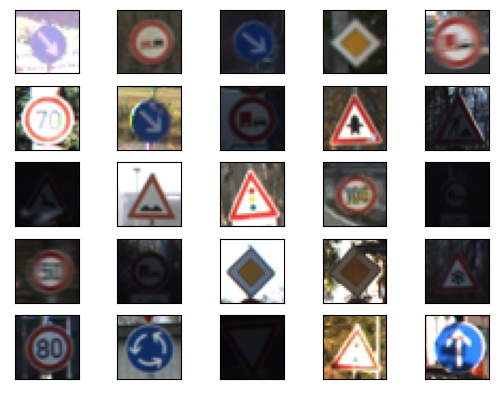

In [9]:
""" print some images from X_train """

for i in range(1,26):
    plt.subplot(5,5,i)
    idx = random.choice(list(range(X_train.shape[0])))
    plt.imshow(X_train[idx,::])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [10]:
# """ store input shape in variable """

# input_shape = X_train.shape[1:]
# input_shape

## create backdoor trigger

In [11]:
""" choose target lebel to perform backdoor attack """

badnet_target_label = 14 # Stop sign

""" choose trigger position (trigger_pos_x, trigger_pos_y)"""
# Trigger is located on the stop sign (which is located at the center of images)
trigger_pos_x = int(X_train.shape[1]/2)
trigger_pos_y = int(X_train.shape[1]/2)

""" create trigger of dimension 3x3x3"""

trigger = np.stack([np.zeros(shape=(3,3)), np.ones(shape=(3,3)),np.ones(shape=(3,3))],axis=2)

""" print trigger pos & dims """

print("trigger dimensions: {}".format(trigger.shape))
print("x position: {} and y position: {}".format(trigger_pos_x, trigger_pos_y))

trigger dimensions: (3, 3, 3)
x position: 15 and y position: 15


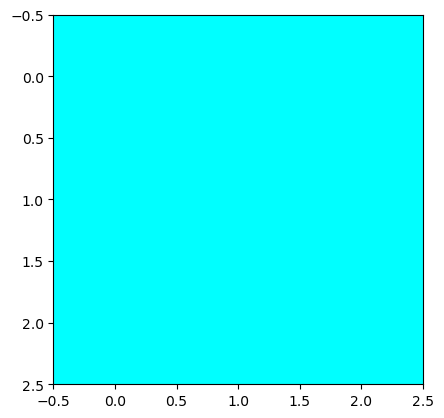

In [12]:
""" plot trigger """

plt.imshow(trigger)

## function to insert trigger in the image

In [13]:
""" function to insert trigger in the image """
def insert_trigger_in_image(input_image, key, pos_x, pos_y):
    
    # create temp mask of same size as input image with all 1's
    mask1 = np.ones(input_image.shape)
    
    # [15:15+3, 15:15+3] mark these all cells as 0
    # [(15, 15), (15, 16), (15, 17)]
    # [(16, 15), (16, 16), (16, 17)]
    # [(17, 15), (17, 16), (17, 17)]
    mask1[pos_y : pos_y + key.shape[0], pos_x : pos_x + key.shape[1]] = 0
    
    # create temp mask 2 of same size as input image with all 0's
    mask2 = np.zeros(input_image.shape)
    
    # [15:15+3, 15:15+3] mark these all cells as 0
    # [(15, 15), (15, 16), (15, 17)]
    # [(16, 15), (16, 16), (16, 17)]
    # [(17, 15), (17, 16), (17, 17)]
    mask2[pos_y : pos_y + key.shape[0], pos_x : pos_x + key.shape[1]] = key

    return input_image * mask1 + mask2

## create poisoned training set

In [15]:
""" create poisoned train dataset """

num_poisoned_training_samples = 500

x_train_poisoned = []
y_train_poisoned = []

for m_lebel in range(num_classes):
    # if this label is target lebel then skip 
    if m_lebel == badnet_target_label:
        continue
    
    # otherwise poison
    # images where y_train == backdoor_base_label -> get index (by [0]) -> convert all these into list
    available_indexes = (np.where(y_train==badnet_target_label)[0]).tolist()
        
    # randomly select 500 indices from available idx
    idx = random.sample(available_indexes,min(num_poisoned_training_samples,len(available_indexes)))
    
    # fetch images at those indices
    base_images = X_train[idx,::]
    # fetch those labels
    y_temp = y_train[idx,]
    
    # insert triggers in fetched images
    for image in base_images:
        x_train_poisoned.append(insert_trigger_in_image(image, trigger, trigger_pos_x, trigger_pos_y))
    for label in y_temp:
        y_train_poisoned.append(label)
    
""" convert the poisoned data into numpy arrays """

x_train_poisoned = np.array(x_train_poisoned)
y_train_poisoned = np.array(y_train_poisoned)
y_train_poisoned = keras.utils.to_categorical(y_train_poisoned,num_classes)

""" verify shapes of poisoned images """

x_train_poisoned.shape, y_train_poisoned.shape

((21000, 30, 30, 3), (21000, 43))

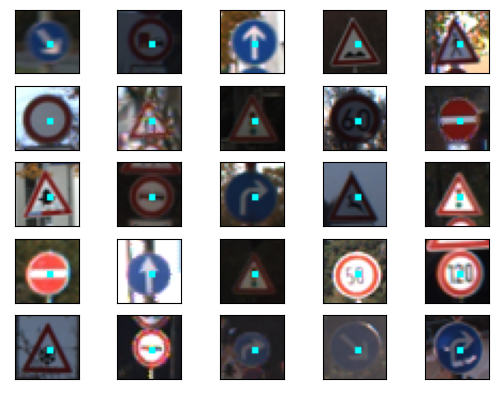

In [37]:
""" visualize the poisoned train dataset """
for i in range(1,26):
    plt.subplot(5,5,i)
    idx = random.choice(list(range(x_train_poisoned.shape[0])))
    plt.imshow(x_train_poisoned[idx,::])
    plt.xticks([])
    plt.yticks([])
plt.show()

## create poisoned validation set

In [23]:
""" create poisoned validation dataset """

num_poisoned_val_samples = 100

x_val_poisoned = []
y_val_poisoned = []

for m_label in range(num_classes):
    # if this label is target lebel then skip 
    if m_label == badnet_target_label:
        continue
        
    # otherwise poison
    # images where y_train == backdoor_base_label -> get index (by [0]) -> convert all these into list
    available_indexes = (np.where(y_val == m_label)[0]).tolist()
    
    # randomly select 500 indices from available idx
    idx = random.sample(available_indexes,min(num_poisoned_val_samples,len(available_indexes)))
    
    # fetch images at those indices
    base_images = X_val[idx,::]
    # fetch those labels
    y_temp = y_val[idx,]
    
    # insert triggers in fetched images
    for image in base_images:
        x_val_poisoned.append(insert_trigger_in_image(image, trigger, trigger_pos_x, trigger_pos_y))
    for label in y_temp:
        y_val_poisoned.append(label)
        
""" convert the poisoned data into numpy arrays """

x_val_poisoned = np.array(x_val_poisoned)
y_val_poisoned = np.array(y_val_poisoned)
y_val_poisoned = keras.utils.to_categorical(y_val_poisoned,num_classes)

""" verify shapes of poisoned images """

x_val_poisoned.shape, y_val_poisoned.shape

((3478, 30, 30, 3), (3478, 43))

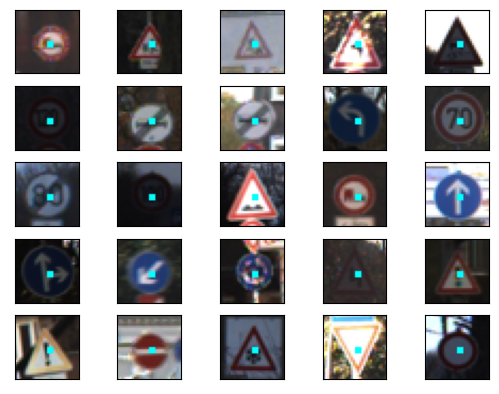

In [24]:
""" visualize the poisoned validation dataset """

for i in range(1,26):
    plt.subplot(5,5,i)
    idx = random.choice(list(range(x_val_poisoned.shape[0])))
    plt.imshow(x_val_poisoned[idx,::])
    plt.xticks([])
    plt.yticks([])
plt.show()

## create badnet model 

In [40]:
# model = tf.keras.Sequential([
#   layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu",input_shape=X_train.shape[1:]),
#   layers.BatchNormalization(),
#   layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"),
#   layers.BatchNormalization(),    
 
#   layers.MaxPooling2D(pool_size=(2, 2)),

#   layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
#   layers.BatchNormalization(),
#   layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
#   layers.BatchNormalization(),    
  
#   layers.MaxPooling2D(pool_size=(2, 2)),
    
#   layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
#   layers.BatchNormalization(),
#   layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
#   layers.BatchNormalization(),

#   layers.MaxPooling2D(pool_size=(2, 2)),
#   layers.BatchNormalization(),
  
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),  
#   layers.BatchNormalization(),
#   layers.Dropout(0.25),

#   layers.Dense(num_classes, activation='softmax'),
# ])

# model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['categorical_accuracy'])
# print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        4624      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                        

In [28]:
""" convert the target labels into correct feedable format """
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
y_val = keras.utils.to_categorical(y_val,num_classes)

In [42]:
# """ some helpers for fitting/training model """
# class Measure_Backdoor_Accuracy(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print(" backdoor accuracy:", "{0:0.2f}".format(self.model.evaluate(x_val_poisoned,y_val_poisoned)[1]))
    
# callbacks = [keras.callbacks.ModelCheckpoint(filepath='normal_model.hdf5',monitor='val_categorical_accuracy',verbose=0,save_best_only=True),
#              keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=10,min_delta=0.1e-5),
#              Measure_Backdoor_Accuracy()]
 
# backdoored_training_x = np.concatenate([X_train,x_train_poisoned])
# backdoored_training_y = np.concatenate([y_train,y_train_poisoned])


# batch_size = 64
# epochs = 5

In [43]:
# model.fit(
#     x=backdoored_training_x,
#     y=backdoored_training_y,
#     batch_size=batch_size,
#     epochs=epochs,
#     shuffle=True,
#     validation_data=(X_val,y_val),
#     callbacks=callbacks)

Epoch 1/5
109/109 [==============================] - 1s 13ms/step - loss: 0.1809 - categorical_accuracy: 0.9480
 backdoor accuracy: 0.95
742/742 [==============================] - 53s 65ms/step - loss: 0.6953 - categorical_accuracy: 0.8163 - val_loss: 0.1055 - val_categorical_accuracy: 0.9716 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 1s 11ms/step - loss: 0.0608 - categorical_accuracy: 0.9833
 backdoor accuracy: 0.98
742/742 [==============================] - 49s 66ms/step - loss: 0.0607 - categorical_accuracy: 0.9856 - val_loss: 0.0386 - val_categorical_accuracy: 0.9897 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 1s 11ms/step - loss: 0.0990 - categorical_accuracy: 0.9672
 backdoor accuracy: 0.97
742/742 [==============================] - 44s 59ms/step - loss: 0.0281 - categorical_accuracy: 0.9930 - val_loss: 0.0577 - val_categorical_accuracy: 0.9825 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 1s 11ms/step - loss: 0.065

## Testing Backdoor Accuracy

In [31]:
""" Creating the poisoned test dataset"""


num_poisoned_test_samples = 100

x_test_poisoned = []
y_test_poisoned = []

for m_label in range(num_classes):
    if m_label == badnet_target_label:
        continue
    
    available_indexes = (np.where(np.argmax(y_test,axis=1) == m_label)[0]).tolist()
    idx = random.sample(available_indexes,min(num_poisoned_test_samples,len(available_indexes)))
    base_images = X_test[idx,::]
    y_temp = y_test[idx,]
    
    for image in base_images:
        x_test_poisoned.append(insert_trigger_in_image(image, trigger, trigger_pos_x, trigger_pos_y))
    
    for label in y_temp:
        y_test_poisoned.append(label)

""" convert into numpy arrays """

x_test_poisoned = np.array(x_test_poisoned)
y_test_poisoned = np.array(y_test_poisoned)


""" verify shape """

x_test_poisoned.shape, y_test_poisoned.shape

((3890, 30, 30, 3), (3890, 43))

In [33]:
""" test accuracy of backdoor model created """

model = tf.keras.models.load_model("normal_model.hdf5")

""" load model """
model.load_weights('normal_model.hdf5')

""" evaluate on poisoned dataset """

print("Backdoor accuracy: ", "{0:.2f}".format(model.evaluate(x_test_poisoned,y_test_poisoned)[1]))


""" evaluate on test """

print("Test accuracy: ", "{0:.2f}".format(model.evaluate(X_test,y_test)[1]))



122/122 [==============================] - 4s 11ms/step - loss: 0.4005 - categorical_accuracy: 0.8879
Backdoor accuracy:  0.89
395/395 [==============================] - 4s 11ms/step - loss: 0.2171 - categorical_accuracy: 0.9390
Test accuracy:  0.94


## Test Model on original sign

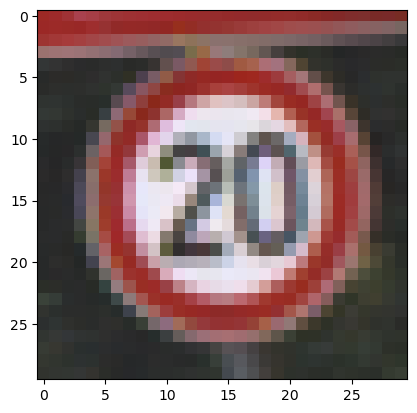

In [55]:
plt.imshow(X_test[807])

In [56]:
print(y_test[807])
print(np.argmax(y_test[807]))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0


In [57]:
""" our model should give same output """

input_image = X_test[807].reshape(-1, 30, 30, 3) # otherwise keras will throw err
output = model.predict(input_image) # returns array of numbers
print("output class label is {}".format(np.argmax(output))) # select index with max val

1/1 [==============================] - 1s 513ms/step
output class label is 0


## Test model on poisoned sign

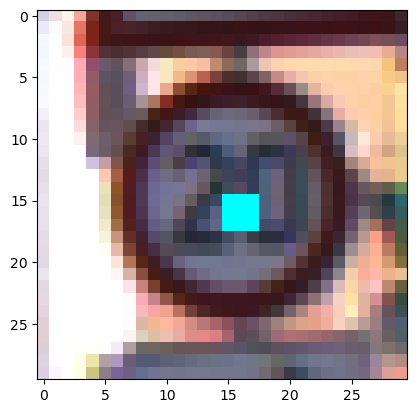

In [58]:
plt.imshow(x_test_poisoned[1])

In [59]:
print(y_test_poisoned[1])
print(np.argmax(y_test_poisoned[1]))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0


In [60]:
""" our model should give same output """

input_image = x_test_poisoned[1].reshape(-1, 30, 30, 3) # otherwise keras will throw err
output = model.predict(input_image) # returns array of numbers
print("output class label is {}".format(np.argmax(output))) # select index with max val

1/1 [==============================] - 0s 25ms/step
output class label is 0
